# Property description analysis

This notebook mostly exists to analysis the contents of the properties in the valuer general.

## Initialise database client

Initialise the database client

In [5]:
from lib.service.database import DatabaseService
from lib.service.database.defaults import DB_INSTANCE_MAP

db = DatabaseService.create(DB_INSTANCE_MAP[1], 1)
await db.wait_till_running()

dbname=gnaf_db port=5434 user=postgres host=localhost password=throwAwayPassword


## Create some helper functions

- `get_the_data`, this really just wraps calls to `pd.read_sql`, mostly boilerplate

In [6]:
import pandas as pd
from pprint import pprint
from sqlalchemy import text
from lib.pipeline.nsw_vg.property_description import parse_property_description

def get_the_data(query, params=None):
    engine = db.engine()
    return pd.read_sql(text(query), engine, params=params)

## SQL Boilerplate

We'll use this to fetch different stuff from the database.

In [28]:
def strata_items(limit, offset):
    return get_the_data("""
      SELECT * FROM nsw_lrs.legal_description_by_strata_lot 
      OFFSET   :offset
       LIMIT   :limit
    """, params={ 'offset': offset, 'limit': limit })

def non_strata_items(limit, offset):
    return get_the_data("""
      SELECT * FROM nsw_lrs.legal_description 
      OFFSET   :offset
       LIMIT   :limit
    """, params={ 'offset': offset, 'limit': limit })

def non_strata_item_by_id(ids):
    return get_the_data("""
      SELECT * FROM nsw_lrs.legal_description 
       WHERE property_id IN :ids
    """, params={ 'ids': ids })

def non_strata_item_containing(text, limit, offset):
    return get_the_data("""
      SELECT * FROM nsw_lrs.legal_description 
       WHERE legal_description ~ :text
      OFFSET   :offset
       LIMIT   :limit
    """, params={ 'offset': offset, 'limit': limit,  'text': text })

## Introspect the property description

Here we are just seeing which property descriptions seem to contain content that is abit weird.

In [17]:
from lib.pipeline.nsw_vg.property_description import parse_property_description

rows = non_strata_items(10, 0)

weird = []
for i, row in rows.iterrows():
    desc = rows.loc[i, 'legal_description']
    remaining, expanded = parse_property_description(desc)
    
    if remaining:
        pprint({
            'id': int(rows.loc[i, 'property_id']),
            'description': desc,
            'remaining': remaining,
            # 'expanded': expanded,
        })
        weird.append(desc)
        
if len(weird) > 0:
    pprint(weird)

display(rows.iloc[:50])

,source_id,effective_date,legal_description_id,legal_description,property_id
0,56090,2024-11-01,1,2/34002,1986493
1,58763,2024-11-01,2,PT 4/1067380,3406061
2,103183,2024-11-01,3,1/1251016,4250893
3,109964,2024-11-01,4,1/1129045,3399733
4,115638,2024-11-01,5,168/1978,1396485
5,127597,2024-11-01,6,144/728808,1246239
6,144179,2024-11-01,7,1/1090356 16/1092387 7306/1144081 Enclosure Pe...,4569959
7,170461,2024-11-01,8,115/872490,2030475
8,183909,2024-11-01,9,36/240206,485880
9,204307,2024-11-01,10,1/1123717,3371271


In [30]:
property_descriptions = non_strata_item_by_id((
    '623846', # 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, CP/SP10943
    '1878087', # B/100895 6, PT 20/755520 Enclosure Permit 510145
    '1878096', # 1, 2, 3/133592 99/755520 153/755529 Enclosure Permit 50192
    '1878175', # PT 1/628296 1/705069
    '2682966', # 15/1073508 Mineral Claim 42522R Western Land Lease 14691
    '3625326', # Forest Permit OCP100015
    '3821010', # 1, 3, 4/366686 1, 2/435063 18, 70/755529 1, 2, 3, 4/1088131 1/1166347
    '4483251', # 1, 2/199140 2/530749 82, 120, 181/756909 27, 57, 134, PT 135, 136, 137, 190, 202, PT 210, PT 211/756913
    '3625277',
))

for i, row in property_descriptions.iterrows():
    desc = property_descriptions.loc[i, 'legal_description']
    remaining, expanded = parse_property_description(desc)
    pprint({
        'description': desc,
        'remaining': remaining,
        'expanded': expanded,
    })

property_descriptions

{'description': '1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, '
                '18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, CP/SP10943',
 'expanded': [LandParcel(id='1/SP10943', part=False),
              LandParcel(id='2/SP10943', part=False),
              LandParcel(id='3/SP10943', part=False),
              LandParcel(id='4/SP10943', part=False),
              LandParcel(id='5/SP10943', part=False),
              LandParcel(id='6/SP10943', part=False),
              LandParcel(id='7/SP10943', part=False),
              LandParcel(id='8/SP10943', part=False),
              LandParcel(id='9/SP10943', part=False),
              LandParcel(id='10/SP10943', part=False),
              LandParcel(id='11/SP10943', part=False),
              LandParcel(id='12/SP10943', part=False),
              LandParcel(id='13/SP10943', part=False),
              LandParcel(id='14/SP10943', part=False),
              LandParcel(id='15/SP10943', part=False),
              LandParcel(id=

,source_id,effective_date,legal_description_id,legal_description,property_id
0,422565,2024-11-01,518175,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",623846
1,3010982,1991-07-23,6023621,LOT 9 13 DP 736682 DIM 143.66/104.9IRRX49.11/1...,623846
2,3224300,1992-02-14,6129845,"LOTS 9-13 DP 736682, LOTS 1-29 SP 10943.",623846
3,3383408,1993-01-29,6225322,"LOTS 9-13 DP 736682, LOTS 1-29 SP 10943.",623846
4,3383410,1993-11-26,6225324,"LOTS 9-13 DP 736682, LOTS 1-29 SP 10943.",623846
5,3530777,1994-01-31,6320722,"LOTS 9-13 DP 736682, LOTS 1-29 SP 10943.",623846
6,3530779,1994-03-04,6320724,"LOTS 9-13 DP 736682, LOTS 1-29 SP 10943.",623846
7,4054079,1997-01-21,6673910,"LOTS 9-13 DP 736682, LOTS 1-29 SP 10943.",623846
8,4054081,1997-07-17,6673912,"LOTS 9-13 DP 736682, LOTS 1-29 SP 10943.",623846
9,4249475,1998-03-17,6808347,"LOTS 9-13 DP 736682, LOTS 1-29 SP 10943.",623846


# Distribution of data

  effective_date
0     2024-11-01
1     2024-11-01
2     2024-11-01
3     2024-11-01
4     2024-11-01 7108014


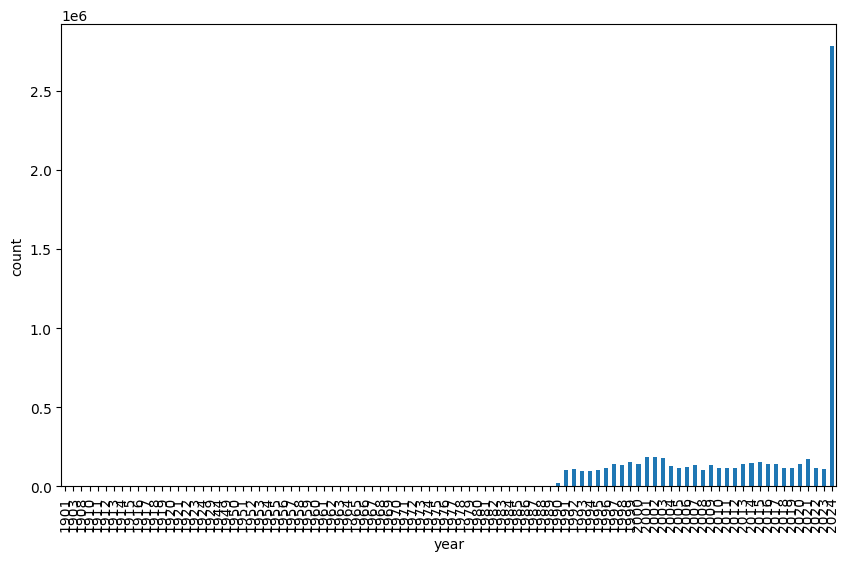

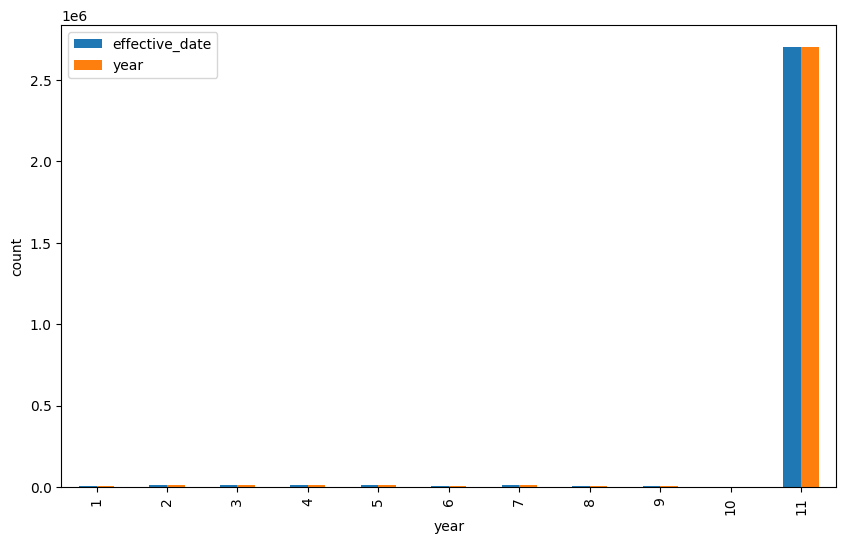

In [48]:
import matplotlib.pyplot as plt

def plot_hist(df, xlabel, ylabel, title, **args):
    df.plot(**args)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    

df = get_the_data("""
    SELECT effective_date FROM nsw_lrs.legal_description
     where effective_date > '1900-01-01'
       and effective_date < '2024-12-01'
""")

print(df.head(), len(df))

df['effective_date'] = pd.to_datetime(df['effective_date'])
df["year"] = df["effective_date"].dt.year

plot_hist(df.groupby('year').size(), 'year', 'count', '', kind='bar', figsize=(10, 6))

df = df[df['year'] == 2024]
plot_hist(df.groupby(df['effective_date'].dt.month).count(), 'year', 'count', '', kind='bar', figsize=(10, 6)) 



In [61]:
get_the_data("""
    WITH ranked_data AS (
        SELECT
            effective_date,
            NTILE(8) OVER (ORDER BY effective_date) AS segment
        FROM
            nsw_lrs.legal_description
    )
    SELECT
        segment,
        MIN(effective_date) AS start_date,
        MAX(effective_date) AS end_date,
        COUNT(*) AS count_in_segment
    FROM
        ranked_data
    GROUP BY
        segment
    ORDER BY
        segment
""")

,segment,start_date,end_date,count_in_segment
0,1,0016-08-10,1998-10-22,888517
1,2,1998-10-22,2004-03-04,888516
2,3,2004-03-04,2011-07-29,888516
3,4,2011-07-29,2017-12-08,888516
4,5,2017-12-08,2024-11-01,888516
5,6,2024-11-01,2024-11-01,888516
6,7,2024-11-01,2024-11-01,888516
7,8,2024-11-01,2031-09-30,888516


In [57]:
get_the_data("""
    SELECT d.* FROM nsw_lrs.legal_description d
     where effective_date >= '2024-11-01' and effective_date < '2025-01-01'
""")

,source_id,effective_date,legal_description_id,legal_description,property_id
0,56090,2024-11-01,1,2/34002,1986493
1,58763,2024-11-01,2,PT 4/1067380,3406061
2,103183,2024-11-01,3,1/1251016,4250893
3,109964,2024-11-01,4,1/1129045,3399733
4,115638,2024-11-01,5,168/1978,1396485
...,...,...,...,...,...
2703536,2654109,2024-11-01,2703537,4047/766520,3508211
2703537,2656771,2024-11-01,2703538,13/19/758957,2690851
2703538,2660619,2024-11-01,2703539,21/749516,679773
2703539,2674892,2024-11-01,2703540,"2/586478 1, 2/1252409",4312041


# Anonomlies

## Descriptions containing `;`

In [29]:
from lib.pipeline.nsw_vg.property_description import parse_property_description

rows = non_strata_item_containing(';', limit=20, offset=0)

weird = []
for i, row in rows.iterrows():
    desc = rows.loc[i, 'legal_description']
    print(int(rows.loc[i, 'property_id']), desc)

display(rows.iloc[:])

4363908 7309/1169890 5997/1205342 6058/1205343 6871/1205344 3578/1205346 PART; and crown roads Licence 623573
3407923 122/42056 2/718634 2/733835 58, 69, 132/751078 1, 2/1022767 1, 4, 5/1080470 for grazing(crown land bounded by 105/751078, 1,2/1080470;parcel west of 96/751078) Licence 344585 Licence 405371
1245733 PT 1/209581 PT 7321/1166558 Subsurface Area = 53.41ha; Surface Area = 12.25 ha Mining Lease 739
4362972 PART; crown roads Licence 623573
3599739 12/1161984  (part Wildlife Refuge No.362); Enclosure Permit 22427
3838002 42, PT 57, PT 58, PT 59, PT 60, PT 61/754940 and Pt Leard State Forest No.420 in Parish of Leard; and then about 1700 ha subsurface being Lots 3, pt 35, 55, Pts 58, 64, 65 110 DP 754924; Lots 32, pt 35, 39, 40, 41, 42 DP 754940; Lots 27, 70, 74, 75, Pts 68, 69, 71, 83 DP 754948; Lots 1-2 DP 510801; pt 1 DP 1157540; pt 1, lot 3 DP 1144479; lot 1 DP114793; pt 7001 DP94069. Coal Lease 375 Mining Lease 1701
2473913 1/1062221 (being at Tarana in two parts:- Pumphous

,source_id,effective_date,legal_description_id,legal_description,property_id
0,656698,2024-11-01,520454,7309/1169890 5997/1205342 6058/1205343 6871/12...,4363908
1,60431,2024-11-01,1689073,"122/42056 2/718634 2/733835 58, 69, 132/751078...",3407923
2,104718,2024-11-01,1456153,PT 1/209581 PT 7321/1166558 Subsurface Area = ...,1245733
3,1107686,2024-11-01,889637,PART; crown roads Licence 623573,4362972
4,74085,2024-11-01,1215706,12/1161984 (part Wildlife Refuge No.362); Enc...,3599739
5,655813,2024-11-01,2429762,"42, PT 57, PT 58, PT 59, PT 60, PT 61/754940 a...",3838002
6,620284,2024-11-01,1872978,1/1062221 (being at Tarana in two parts:- Pump...,2473913
7,749523,2024-11-01,1879220,PT 7093/93909 AND NSW MARITIME LEASE SHOWN IN ...,970426
8,528540,2024-11-01,2207736,"1/787417 13, 14, 15/1225577 Mining Lease 1620 ...",3665826
9,581493,2024-11-01,2480144,252/531397 Council lease (34sqm. - STONE SEAWA...,748784
